# LXM

> LXM: Better Splittable Pseudorandom Number Generators (and Almost as Fast)
> - Paper: https://dl.acm.org/doi/abs/10.1145/3485525
> - Video: https://youtu.be/OXurCqln_qc


En el 2021 Guy Steele y Sebastiano Vigna presentaron un generador de números pseudo aleatorios (PRNG) que se construye a partir de otro PRNG en donde colaboro Guy Steele llamado SplitMix. La principal propiedad de ambos PRNGs es que estos generadores son partibles (_splittable_), es decir, se pueden dividir en dos nuevos generadores estadísticamente independientes, lo cual es de gran utilidad en ambientes concurrentes.

LXM se basa en combinar tres ideas: un generador lineal congruente (la L), un generador basado en XORs (la X) y el resultado de la combinación de esos dos generadores utilizarlo como input en una función mezcladora (la M).

En este trabajo nos centraremos específicamente en la parte práctica del algoritmo y lo re-implementaremos en nuestro propio código, evitando hablar tanto de la concurrencia como de la propiedad partible del algoritmo (lo cual consiste de la mayoría del paper de Guy Steele y Sebastiano Vigna). Las ideas principales surgen de la sección 2 del paper (`THE LXM GENERATION ALGORITHM`)

## Ejercicio 1

Sobre el generador de números al azar propuesto en el paper asignado, se pide:
- Implementarlo en función de lo especificado en el documento.
- Modificarlo (si aplica) para obtener números al azar entre 0 y 1
- Realizar los gráficos que se consideren adecuados para mostrar las distribuciones de números al azar
generados en ambos casos (explicar que se busca interpretar con cada uno)

In [1]:
def LXM(s, m=2891336453, a=1310709051, x0=11565345, x1=5242836, k=64):
    
    # https://gist.github.com/trietptm/5cd60ed6add5adad6a34098ce255949a
    rotl = lambda val, r_bits, max_bits: \
        (val << r_bits%max_bits) & (2**max_bits-1) | \
        ((val & (2**max_bits-1)) >> (max_bits-(r_bits%max_bits)))    
    
    while True:
        # Combining operation
        z = s + x0
        # Mixing function (lea64)
        z = (z ^ (z >> 32)) * 0xdaba0b6eb09322e3
        z = (z ^ (z >> 32)) * 0xdaba0b6eb09322e3
        z = (z ^ (z >> 32))
        z &= (2**k) - 1
        # Update the LCG subgenerator
        s = (m * s + a)
        # Update the XBG subgenerator (xoroshiro128v1_0)
        q0 = x0; q1 = x1
        q1 ^= q0
        q0 = rotl(q0, 24, k)
        q0 = q0 ^ q1 ^ (q1 << 16)
        q1 = rotl(q1, 37, k)
        x0 = q0; x1 = q1
        # Return result
        yield z, z/2**k
        

g = LXM(42)
for r, i in zip(g,range(5)):
    print(r)

(14642682842691032128, 0.793781427453092)
(3976233945295229431, 0.2155520740899848)
(13712333072192769468, 0.7433470653358116)
(5286953016995676793, 0.28660629734277526)
(9506751871773882404, 0.515362051632894)


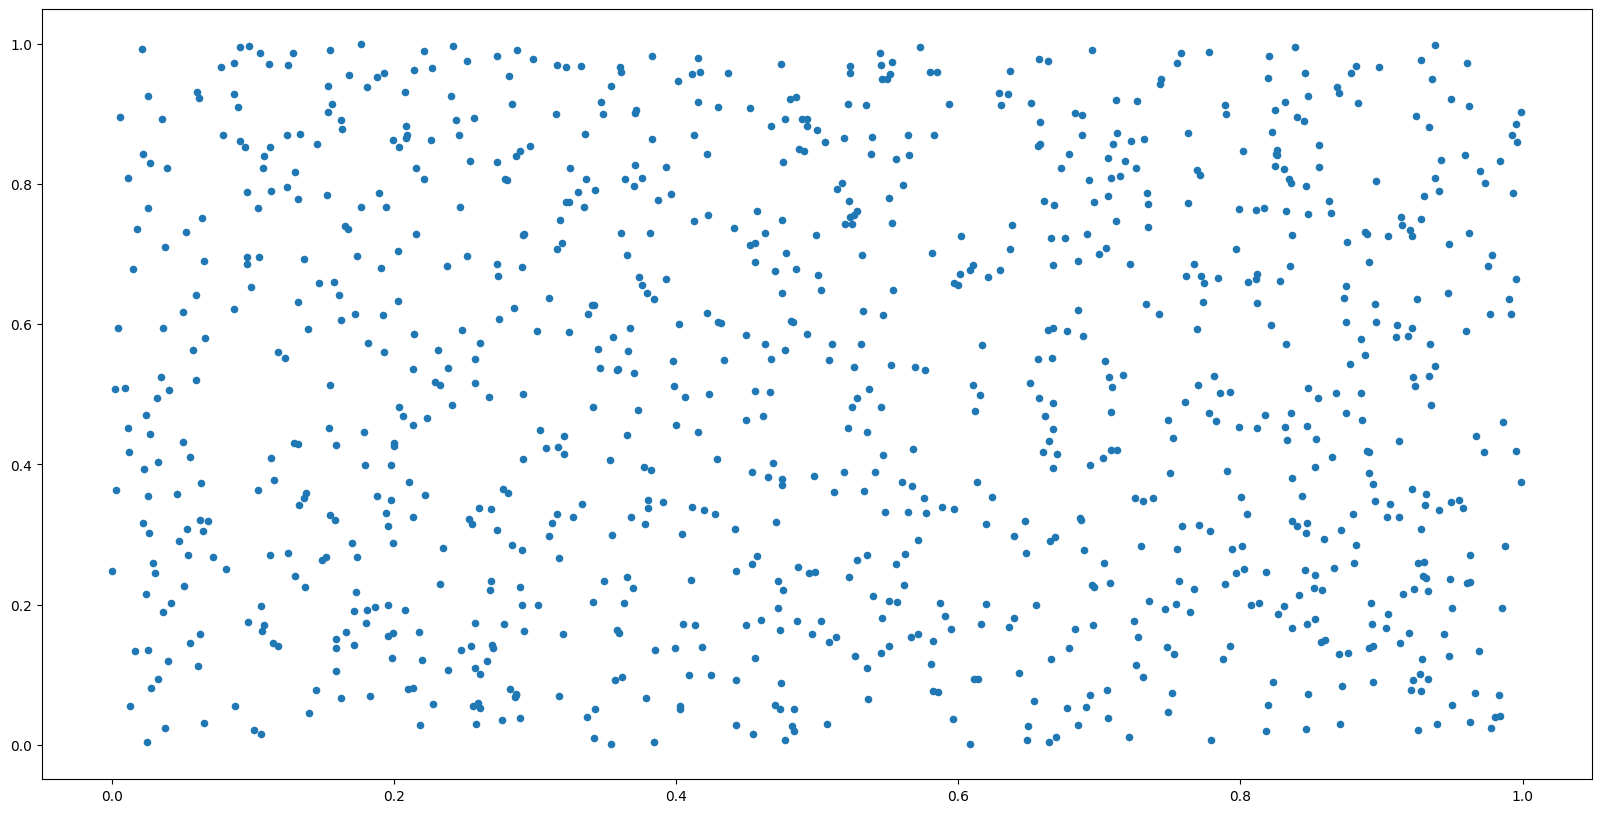

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

x = []; y = []
for i in range(1000):
    z, zf = next(g)
    x.append(zf)
    z, zf = next(g)
    y.append(zf)
plt.scatter(x,y,20)

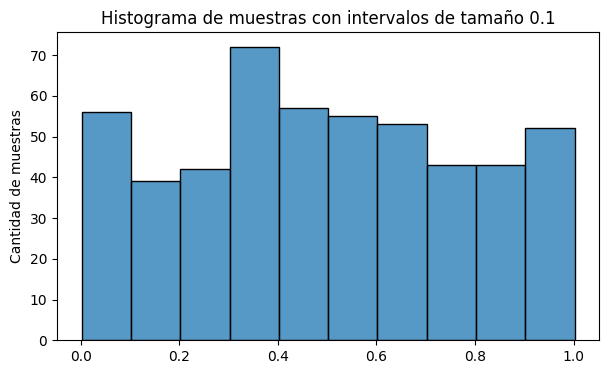

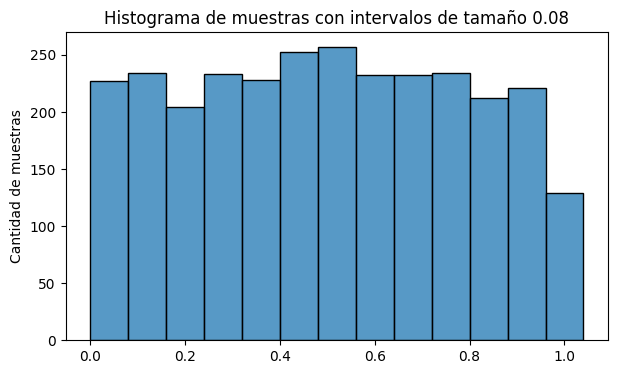

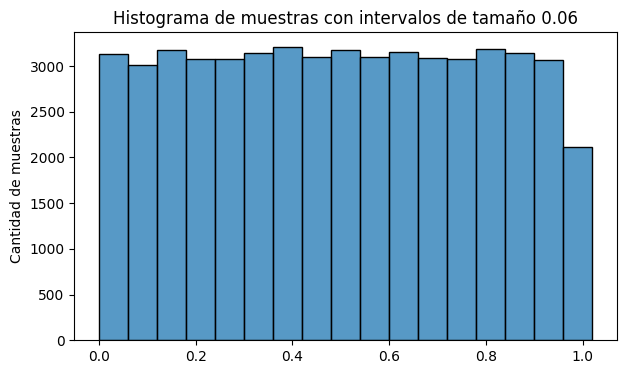

In [3]:
import seaborn as sns

# Regla de Struges
cantidades = [512, 2896, 52016]
intervalos = [0.1, 0.08, 0.06]

for i in range(len(cantidades)):
    intervalo = intervalos[i]
    cantidad = cantidades[i]
    muestras = []
    
    for j in range(cantidad):
        muestras.append(next(g)[1])
    
    fig, ax = plt.subplots(figsize = ( 7 , 4 ))
    sns.histplot(data=muestras, binwidth=intervalo)
    ax.set_title("Histograma de muestras con intervalos de tamaño " + str(intervalo))
    ax.set_ylabel("Cantidad de muestras")
        
    plt.show()
    

<AxesSubplot:>

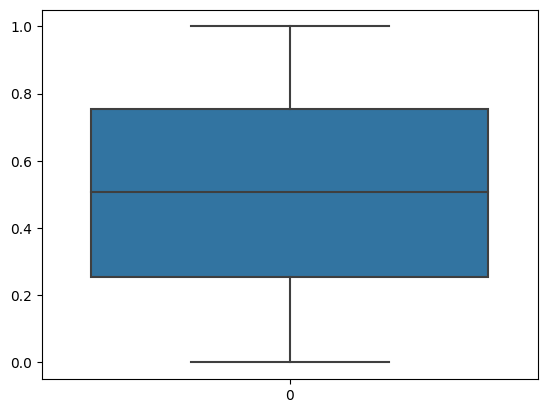

In [4]:
muestras = []
    
for j in range(10000):
    muestras.append(next(g)[1])
    
sns.boxplot(muestras)

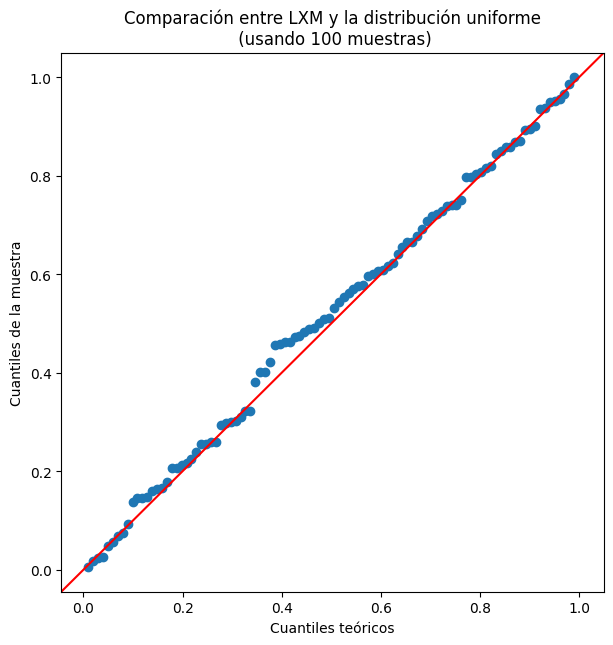

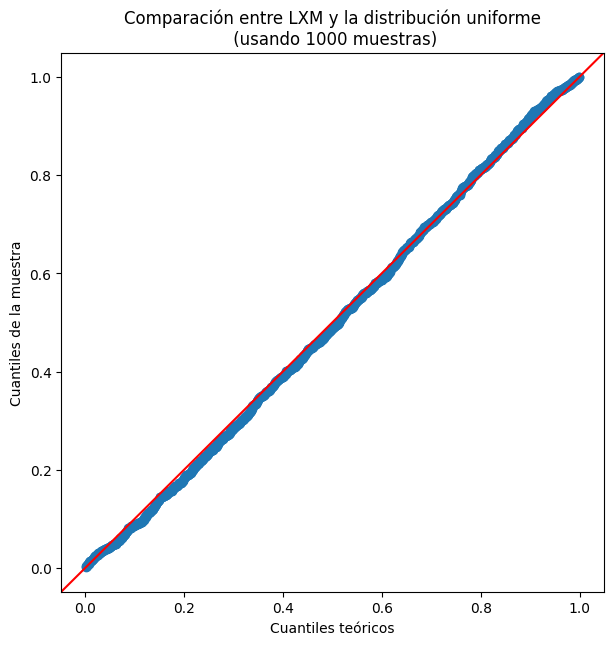

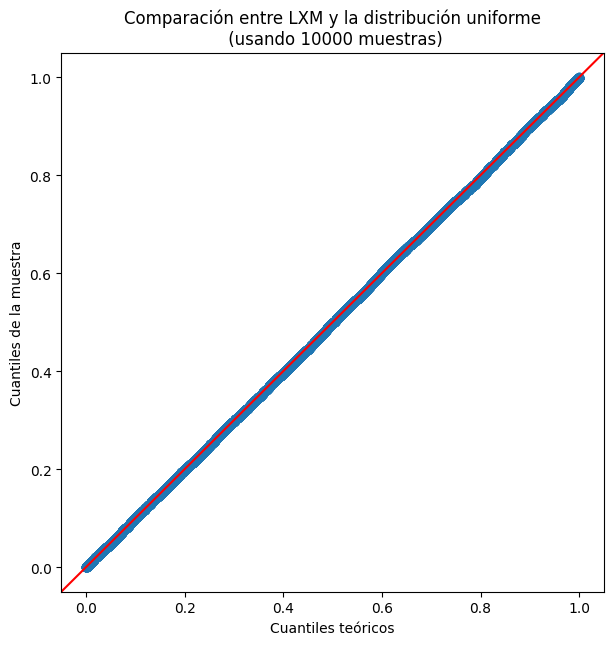

In [5]:
import numpy as np
import statsmodels.api as sm
import pylab as py
from scipy.stats import uniform

cantidades = [100, 1000, 10000]

for cantidad in cantidades:

    muestras = []
    
    for j in range(cantidad):
        muestras.append(next(g)[1])
    
    muestras_np = np.array(muestras)
    fig, ax = plt.subplots(figsize = ( 7 , 7 ))
    sm.qqplot(muestras_np, dist=uniform, line='45', ax=ax)
    ax.set_title("Comparación entre LXM y la distribución uniforme\n (usando " + str(cantidad) + " muestras)")
    ax.set_ylabel("Cuantiles de la muestra")
    ax.set_xlabel("Cuantiles teóricos")
    py.show()

## Ejercicio 2

Para los generadores implementados en el ejercicio 1:
- Proponer, y realizar, al menos 3 tests para evaluar su comportamiento.
- Evaluar e interpretar los resultados de cada test para distintos tamaños de muestras.

## Ejercicio 3

Utilizando el generador implementado en el ejercicio 1:
- Implementar un método para generar variables aleatorias con distribución normal con media 10 y desvío 2.
- Graficar la distribución que siguen los números pseudoaleatorios generados.
- Realizar, al menos 2 tests, de los explicados en la materia, para verificar si los números generados siguen la distribución pedida (evalué los resultados para distintos tamaños de muestra).

In [6]:
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy as sp
pi = np.pi
e = np.e

In [7]:
gen = LXM(42)

def generar_exponencial(lambda_):           #OK
  u_1 = next(gen)[1]
  return -np.log(u_1)/lambda_

def cociente(t):                            #OK
  return e**((-(t-1)**2)/2)

def transformar_gaussiana(x, mean, std):    #OK
  return x*std + mean

def generar_normal_0_1():
  no_aceptada = True
  while(no_aceptada):
    exp_1 = generar_exponencial(1)
    prob = cociente(exp_1)                
    if(next(gen)[1] < prob):
      no_aceptada = False
      z = exp_1
      if(next(gen)[1] < 0.5):
        z = -z
  return z

3.b) Graficar la distribución que siguen los números pseudoaleatorios generados.

In [8]:
m1, m2, m3 = [], [], []     #muestras
for i in range(100):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m1.append(z2)

for i in range(1000):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m2.append(z2)

for i in range(10000):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m3.append(z2)

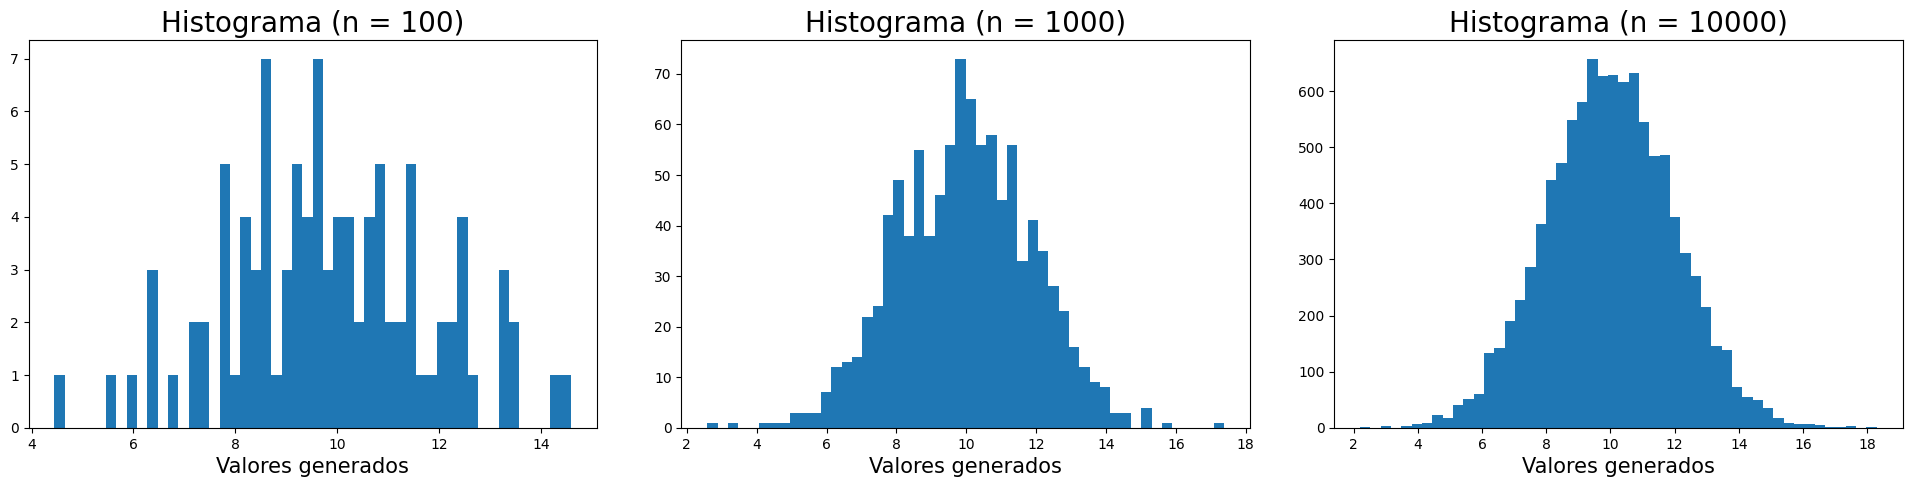

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
fig.tight_layout(pad=3)
ax1.hist(m1, 50)
ax1.set_xlabel('Valores generados', fontsize=15)
ax1.set_title("Histograma (n = 100)", fontsize=20)
ax2.hist(m2, 50)
ax2.set_xlabel('Valores generados', fontsize=15)
ax2.set_title("Histograma (n = 1000)", fontsize=20)
ax3.hist(m3, 50)
ax3.set_xlabel('Valores generados', fontsize=15)
ax3.set_title("Histograma (n = 10000)", fontsize=20)

plt.show();

3.c) Realizar, al menos 2 tests, de los explicados en la materia, para verificar si los números generados siguen la distribución pedida (evalúe los resultados para distintos tamaños de muestra).

3.c.1) Test de Kolmogorov-Smirnov

El test de Kolmogorov-Smirnov se utiliza para decidir si una muestra proviene de una población con una distribución específica. 

Se tiene una distribución de probabilidad acumulada, la cual se propone como distribución teórica de la muestra, y otra distribución de probabilidad empirica, generada a partir de la muestra.

En este caso tenemos las hipótesis:
<br>
<br>
$H_0$: La muestra pertenece a una poblacion con la distribución teórica propuesta
<br>
$H_1$: La muestra no pertenece a una poblacion con la distribución teórica propuesta.
<br>
<br>
El test provee como resultados un estadístico y un p-valor. Cuando el p-valor obtenido es superior a cierto umbral --usualmente 0.05--, decimos que no podemos rechazar la hipótesis de que los datos provienen de una población con la distribución teórica propuesta.

In [43]:
m1_ks, m2_ks, m3_ks = [], [], []     #muestras
for i in range(100):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m1_ks.append(z2)

for i in range(1000):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m2_ks.append(z2)

for i in range(5000):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m3_ks.append(z2)

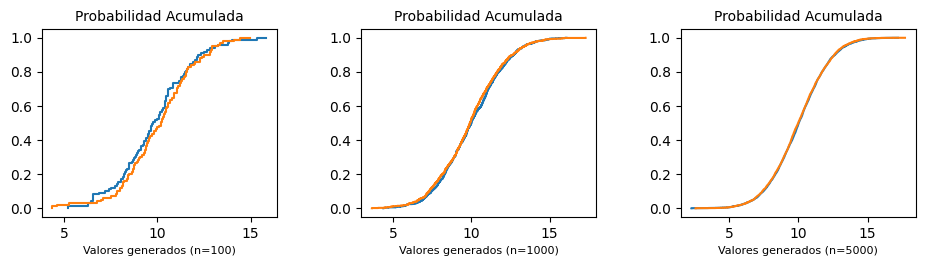

In [45]:
figsts, (ax1sts, ax2sts, ax3sts) = plt.subplots(1, 3, figsize=(10, 3))
figsts.tight_layout(pad=3)
state = np.random.default_rng()
dist_teorica_1 = sp.stats.norm(loc=10, scale=2).rvs(size=100, random_state=state)
dist_teorica_2 = sp.stats.norm(loc=10, scale=2).rvs(size=1000, random_state=state)
dist_teorica_3 = sp.stats.norm(loc=10, scale=2).rvs(size=5000, random_state=state)

yval1 = np.linspace(0.0, 1.0,num=100)
ax1sts.step(x=np.sort(m1_ks), y=yval1)
ax1sts.step(x=np.sort(dist_teorica_1), y=yval1)
ax1sts.set_xlabel('Valores generados (n=100)', fontsize=8)
ax1sts.set_title("Probabilidad Acumulada", fontsize=10)

yval2 = np.linspace(0.0, 1.0,num=1000)
ax2sts.step(x=np.sort(m2_ks), y=yval2)
ax2sts.step(x=np.sort(dist_teorica_2), y=yval2)
ax2sts.set_xlabel('Valores generados (n=1000)', fontsize=8)
ax2sts.set_title("Probabilidad Acumulada", fontsize=10)

yval3 = np.linspace(0.0, 1.0,num=5000)
ax3sts.step(x=np.sort(m3_ks), y=yval3)
ax3sts.step(x=np.sort(dist_teorica_3), y=yval3)
ax3sts.set_xlabel('Valores generados (n=5000)', fontsize=8)
ax3sts.set_title("Probabilidad Acumulada", fontsize=10)

plt.show();

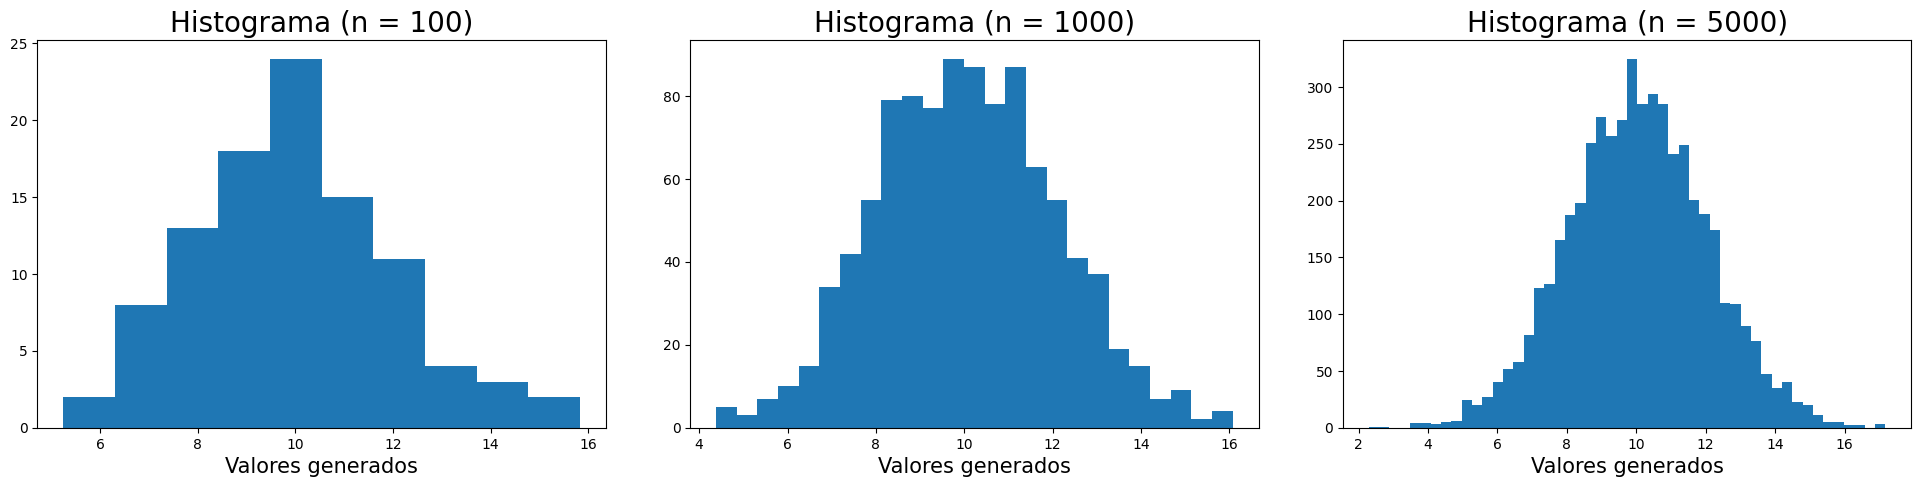

In [46]:
figks, (ax1ks, ax2ks, ax3ks) = plt.subplots(1, 3, figsize=(20, 5))
figks.tight_layout(pad=3)
ax1ks.hist(m1_ks, 10)
ax1ks.set_xlabel('Valores generados', fontsize=15)
ax1ks.set_title("Histograma (n = 100)", fontsize=20)
ax2ks.hist(m2_ks, 25)
ax2ks.set_xlabel('Valores generados', fontsize=15)
ax2ks.set_title("Histograma (n = 1000)", fontsize=20)
ax3ks.hist(m3_ks, 50)
ax3ks.set_xlabel('Valores generados', fontsize=15)
ax3ks.set_title("Histograma (n = 5000)", fontsize=20)

plt.show();

In [47]:
from scipy import stats
ks1 = stats.kstest(m1_ks, dist_teorica_1, alternative='two-sided')
ks2 = stats.kstest(m2_ks, dist_teorica_2, alternative='two-sided')
ks3 = stats.kstest(m3_ks, dist_teorica_3, alternative='two-sided')

display ("Valor del estadístico del test Kolmogorov-Smirnov con n = 100: " + str(ks1.statistic))
display ("P-valor del test Kolmogorov-Smirnov con n = 100: " + str(ks1.pvalue))
display ("Valor del estadístico del test Kolmogorov-Smirnov con n = 1000: " + str(ks2.statistic))
display ("P-valor del test Kolmogorov-Smirnov con n = 1000: " + str(ks2.pvalue))
display ("Valor del estadístico del test Kolmogorov-Smirnov con n = 5000: " + str(ks3.statistic))
display ("P-valor del test Kolmogorov-Smirnov con n = 5000: " + str(ks3.pvalue))

'Valor del estadístico del test Kolmogorov-Smirnov con n = 100: 0.09'

'P-valor del test Kolmogorov-Smirnov con n = 100: 0.8154147124661313'

'Valor del estadístico del test Kolmogorov-Smirnov con n = 1000: 0.05'

'P-valor del test Kolmogorov-Smirnov con n = 1000: 0.16411447756429137'

'Valor del estadístico del test Kolmogorov-Smirnov con n = 5000: 0.021'

'P-valor del test Kolmogorov-Smirnov con n = 5000: 0.22021895014259807'

Dado que en todos los casos el p-valor es superior a 0.05, no rechazamos la hipótesis de que los datos provienen de una distribución normal.

3.c.2) Test de Shapiro-Wilk

El test de Shapiro-Wilk está diseñado para decidir si una muestra aleatoria proviene de una distribución normal. 
En este caso se cuenta con las siguientes hipótesis:

$H_0$: Los datos provienen de una distribución normal

$H_1$: Los datos no provienen de una distribución normal

El test provee como resultados un estadístico y un p-valor. Cuando el p-valor obtenido es superior a cierto umbral --usualmente 0.05--, decimos que no podemos rechazar la hipótesis de que los datos provienen de una distribución normal.

La implementación utilizada (scipy) indica que para muestras de más de 5000 números, se pierde precisión en los valores del test. Por lo que se realizará el test para muestras de tamaños N = 100, 1000 y 5000. (Ver: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html?highlight=shapiro)

In [13]:
m1_sw, m2_sw, m3_sw = [], [], []     #muestras
for i in range(100):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m1_sw.append(z2)

for i in range(1000):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m2_sw.append(z2)

for i in range(5000):
  z1 = generar_normal_0_1()
  z2 = transformar_gaussiana(z1, 10, 2)
  m3_sw.append(z2)

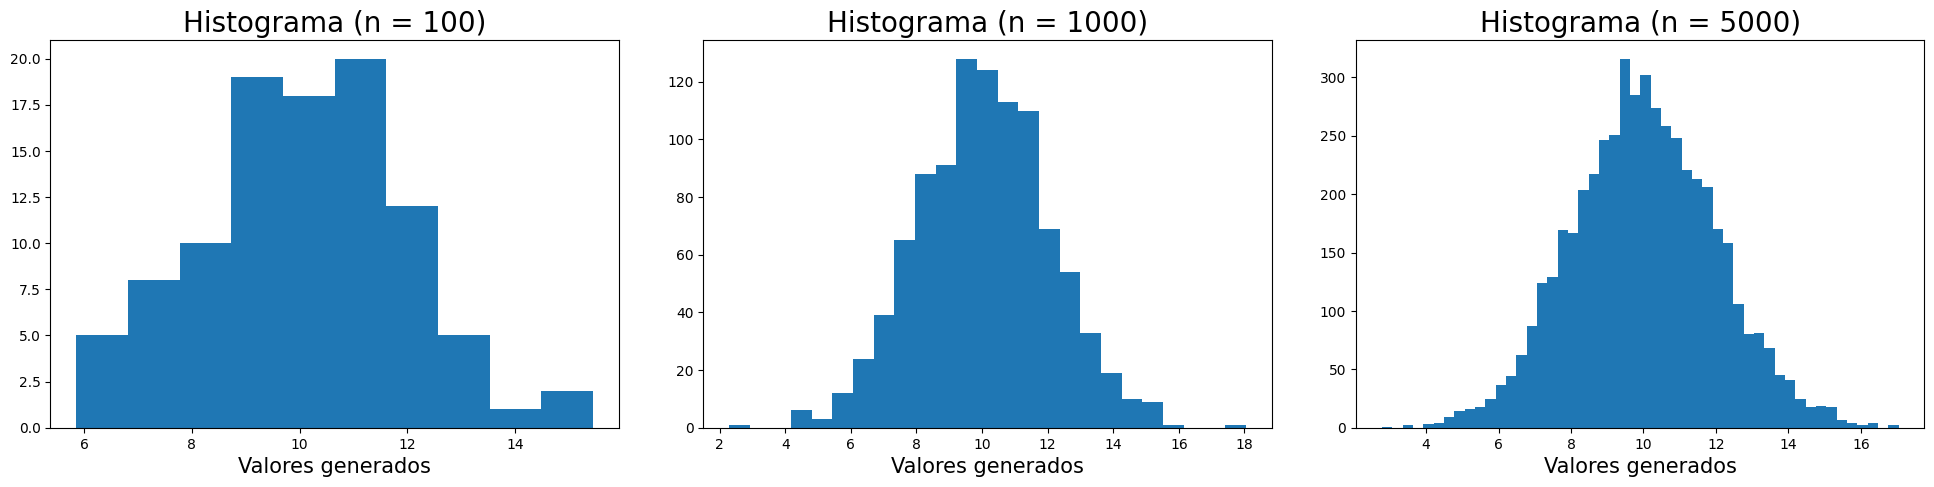

In [14]:
figsw, (ax1sw, ax2sw, ax3sw) = plt.subplots(1, 3, figsize=(20, 5))
figsw.tight_layout(pad=3)
ax1sw.hist(m1_sw, 10)
ax1sw.set_xlabel('Valores generados', fontsize=15)
ax1sw.set_title("Histograma (n = 100)", fontsize=20)
ax2sw.hist(m2_sw, 25)
ax2sw.set_xlabel('Valores generados', fontsize=15)
ax2sw.set_title("Histograma (n = 1000)", fontsize=20)
ax3sw.hist(m3_sw, 50)
ax3sw.set_xlabel('Valores generados', fontsize=15)
ax3sw.set_title("Histograma (n = 5000)", fontsize=20)

plt.show();


In [15]:
from scipy import stats
shapiro1 = stats.shapiro(m1_sw)
shapiro2 = stats.shapiro(m2_sw)
shapiro3 = stats.shapiro(m3_sw)

display ("Valor del estadístico del test Shapiro-Wilk con n = 100: " + str(shapiro1.statistic))
display ("P-valor del test Shapiro-Wilk con n = 100: " + str(shapiro1.pvalue))
display ("Valor del estadístico del test Shapiro-Wilk con n = 1000: " + str(shapiro2.statistic))
display ("P-valor del test Shapiro-Wilk con n = 1000: " + str(shapiro2.pvalue))
display ("Valor del estadístico del test Shapiro-Wilk con n = 5000: " + str(shapiro3.statistic))
display ("P-valor del test Shapiro-Wilk con n = 5000: " + str(shapiro3.pvalue))

'Valor del estadístico del test Shapiro-Wilk con n = 100: 0.9904636740684509'

'P-valor del test Shapiro-Wilk con n = 100: 0.7020654678344727'

'Valor del estadístico del test Shapiro-Wilk con n = 1000: 0.9989786744117737'

'P-valor del test Shapiro-Wilk con n = 1000: 0.8619867563247681'

'Valor del estadístico del test Shapiro-Wilk con n = 5000: 0.9995430111885071'

'P-valor del test Shapiro-Wilk con n = 5000: 0.28750666975975037'

Dado que el p-valor es superior a 0.05, no rechazamos la hipótesis de que los datos provienen de una distribución normal.

---

## Ejercicio 4

La llegada de vehículos a un estacionamiento sigue un proceso de Poisson de tasa λ vehículos/hora. En el trabajo práctico se incluye un archivo con números pseudoaleatorios que representan los tiempos entre arribos de dichos vehículos.
- Realice una estimación de la tasa de arribos y proponga un test para evaluar si los números pseudoaleatorios provistos siguen la distribución esperada.
- Utilizando el GCL implementado en el Ejercicio 1 simular la llegada de vehículos durante un mes. Graficar la cantidad de arribos en función del tiempo.
- Generar 1000 realizaciones del proceso de Poisson para estimar las siguientes probabilidades:
  1. Probabilidad que el primer vehículo arribe antes de los 10 minutos.
  2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.
  3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.

Comparar con los valores teóricos.

## Ejercicio 5

A partir del generador de número al azar implementado en el ejercicio 1, y del dataset provisto, obtenido del sitio de datos abiertos del Gobierno de la Ciudad de Buenos Aires (data.buenosaires.gob.ar), el cual contiene información geográfica de barrios de la Ciudad de Buenos Aires, se pide:
- Proponer e implementar un método que permita generar coordenadas (latitud y longitud) distribuidas de forma uniforme en cada uno de los barrios.
- Graficar los puntos generados en el mapa

## Ejercicio 6
Comparar los resultados obtenidos en los ejercicios 1 a 5 utilizando el generador de números al azar propuesto en el paper asignado, con los resultados que se obtendrían con un Generador Congruencial Lineal de módulo 232, multiplicador 1013904223, incremento de 1664525 y semilla igual a la parte entera del promedio de los números de padrón de los integrantes del grupo.